# Ensemble Network
In this notebook we show our solution for finding the best ensemble networks using the models obtained during the pretrained analysis.


## Load the dataset from Kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d ikarus777/best-artworks-of-all-time
! unzip best-artworks-of-all-time.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflati

## Data preprocessing

In [ ]:
artists = pd.read_csv('artists.csv')
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
#artists_top = artists_top.loc[artists_top['paintings'] >200]
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [ ]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

Next step is to solve a problem: the downloaded dataset present two directory containing the same paintings but they have different name. What we do in the next cells is to create a single directory called 'Albrecht_Durer' containing one copy of each painting, and then we delete all unuseful directories.

In [ ]:
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name
images_dir = 'images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

In [ ]:
! mv '/content/images/images/Albrecht_Du╠Иrer' /content/images/images/Albrecht_Dürer

In [ ]:
! rm -R '/content/images/images/Albrecht_DuтХа├кrer' 
! rm -R '/content/resized'

## Data fetch

In [ ]:
import pathlib
import os

IMAGE_DIR = '/content/images/'
TRAIN_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'train'))
TEST_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'test'))

BATCH_SIZE = 128
RANDOM_SEED = 42

In [ ]:
import os
import numpy as np
import shutil

rootdir= '/content/images/images' #path of the original folder
classes = os.listdir(rootdir)

for i, c in enumerate(classes, start=1):
  if c not in artists_top_name.tolist():
    shutil.rmtree(rootdir + '/' + c)
    continue
  if not os.path.exists(rootdir + '/train/' + c):
    os.makedirs(rootdir + '/train/' + c)
  if not os.path.exists(rootdir + '/test/' + c):  
    os.makedirs(rootdir + '/test/' + c)

  source = os.path.join(rootdir, c)
  allFileNames = os.listdir(source)

  np.random.shuffle(allFileNames)

  test_ratio = 0.10
  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + c)

  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + c)

In [ ]:
! mv /content/images/images/train /content/images
! mv /content/images/images/test /content/images
! rm -r /content/images/images

## Creating the validation set and the testset to use for testing the ensemble

First thing to do is to define the sizes needed by the images for creating the sets:

In [ ]:
IMAGE_HEIGHT_VGG = 256
IMAGE_WIDTH_VGG = 256

IMAGE_WIDTH_RESNET = 224
IMAGE_HEIGHT_RESNET = 224

IMAGE_WIDTH_INCEPTION = 299
IMAGE_HEIGHT_INCEPTION = 299

BATCH_SIZE = 64
RANDOM_SEED = 42
VALIDATION_SPLIT = 0.10

Then we use them to obtain the different validation sets

In [ ]:
import tensorflow as tf

val_images_vgg = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, 
    image_size=(IMAGE_WIDTH_VGG, IMAGE_HEIGHT_VGG), shuffle=True, seed=RANDOM_SEED,
    validation_split=VALIDATION_SPLIT, subset='validation',
    interpolation='bilinear', follow_links=False
)

val_images_resnet = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, 
    image_size=(IMAGE_WIDTH_RESNET, IMAGE_HEIGHT_RESNET), shuffle=True, seed=RANDOM_SEED,
    validation_split=VALIDATION_SPLIT, subset='validation',
    interpolation='bilinear', follow_links=False
)

val_images_inception = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, 
    image_size=(IMAGE_WIDTH_INCEPTION, IMAGE_HEIGHT_INCEPTION), shuffle=True, seed=RANDOM_SEED,
    validation_split=VALIDATION_SPLIT, subset='validation',
    interpolation='bilinear', follow_links=False
)

Found 3864 files belonging to 11 classes.
Using 386 files for validation.
Found 3864 files belonging to 11 classes.
Using 386 files for validation.
Found 3864 files belonging to 11 classes.
Using 386 files for validation.


Then we use them to obtain the different test sets:

In [ ]:
import tensorflow as tf

test_images_vgg = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR, labels='inferred', label_mode='categorical',
        class_names=None, color_mode='rgb', batch_size=BATCH_SIZE,
        image_size=(IMAGE_WIDTH_VGG, IMAGE_HEIGHT_VGG),
        shuffle=True, seed=RANDOM_SEED, interpolation='bilinear', follow_links=False
)
test_images_resnet = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE,
    image_size=(IMAGE_WIDTH_RESNET, IMAGE_HEIGHT_RESNET),
    shuffle=True, seed=RANDOM_SEED, interpolation='bilinear', follow_links=False
)
test_images_inception = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE,
    image_size=(IMAGE_WIDTH_INCEPTION, IMAGE_HEIGHT_INCEPTION),
    shuffle=True, seed=RANDOM_SEED, interpolation='bilinear', follow_links=False
)


Found 435 files belonging to 11 classes.
Found 435 files belonging to 11 classes.
Found 435 files belonging to 11 classes.


## The Ensemble classes
Before the ensemble class we need to define the models we have intention to use:

In [ ]:
vgg16 = ['vgg16_finetuned_1_dropout_reg.keras',
             'vgg16_finetuned_2_dropout_reg.keras',
             'vgg16fe.keras',
             'vgg16feDropout.keras',
             'vgg16finetuned_2_dropout.keras',
             'vgg16finetuned1.keras',
             'vgg16finetuneddropout.keras']
resnet50 = ['resnet50.keras',
            'resnet50finetuned1.keras',
            'resnet50finetuned2.keras',
            'resnet50ft1dense.keras',
            'resnet50ft2dense.keras']
resnet101 = ['resnet101_dense.keras',
             'resnet101_finetune4_dropout.keras',
             'resnet101_finetuning_block4.keras',
             'resnet101_finetuning_block5.keras',
             'resnet101deeper.keras',
             'resnet101fe.keras',
             'resnet101finetuning1.keras']
inception = ['inceptionfe.keras',
             'inceptionft1.keras',
             'inceptionft2.keras',
             'inceptionft3.keras',
             'inceptionft3drop.keras']

We also import some packages needed:

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as ks
import random
import string

Then we log in to Google Drive in order to obtain the keras models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### VGG Ensemble class
Then we can define the ensemble class as follow:

In [ ]:
class EnsembleVGG:
    def __init__(self, set_vgg):
        self.set_vgg = set_vgg

        # create list of models
        self.model_list = []

        base_dir = '/content/drive/MyDrive/Fazzari_Ramo/Models/'
        # VGG16
        for name in vgg16:
            tmp = ks.models.load_model(base_dir + 'vgg16/' + name)
            tmp._name = name
            for i, layer in enumerate(tmp.layers):
                layer.trainable = False
                layer._name = 'ensemble_' + str(i + 1) + '_' + layer.name
            self.model_list.append(ks.models.load_model(base_dir + 'vgg16/' + name))


    def ensembleModel(self, active_models):
        models = []
        for i, model in enumerate(self.model_list):
            if active_models[i] == 1:
                model._name = str(i)
                models.append(model)
        model_input = ks.Input(shape=(IMAGE_WIDTH_VGG, IMAGE_HEIGHT_VGG, 3))
        model_outputs = [model(model_input) for model in models]
        ensemble_output = ks.layers.Average()(model_outputs)
        ensemble_model = ks.Model(inputs=model_input, outputs=ensemble_output)
        ensemble_model.compile(metrics=['accuracy'])
        return ensemble_model

    def evaluate(self, ensemble_model):
        loss, acc = ensemble_model.evaluate(self.set_vgg)
        return acc

    def ensemble_and_evaluate(self, active_models):
        if np.sum(active_models) == 0:
            return 0.0
        elif np.sum(active_models) == 1:
            print(active_models.index(1))
            return self.evaluate(self.model_list[active_models.index(1)])
        else:
            return self.evaluate(self.ensembleModel(active_models))

    def models_len(self):
        return len(self.model_list)

### Genetic Algorithm Workflow for VGG Ensemble

In this section we use the ensemble class in order to find the best ensemble method using the precomputed models.
The first step is to download *Deap*

In [ ]:
!pip install deap

     |████████████████████████████████| 160 kB 5.4 MB/s 


Then we import all we need to use it 

In [ ]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

Next step is to define the problem (we also save the number of the models)

In [ ]:
ensemble = EnsembleVGG(val_images_vgg)
INDIVIDUAL_LENGTH = ensemble.models_len()

We define the Genetic Algorithm constants:

In [ ]:
POPULATION_SIZE = 8
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 5
HALL_OF_FAME_SIZE = 1

We set the random seed:

In [ ]:
RANDOM_SEED = 42 
random.seed(RANDOM_SEED)

We create the toolbox:

In [ ]:
toolbox = base.Toolbox()

Then we define the functions for creating the population:

In [ ]:
# create an operator that randomly returns 0 or 1
toolbox.register('zeroOrOne', random.randint, 0, 1)

# define a single objective, maximizing fitness strategy:
creator.create('FitnessMax', base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create('Individual', list, fitness=creator.FitnessMax)

# create the individual operator to fill up an Individual instance:
toolbox.register('individualCreator', tools.initRepeat, creator.Individual, toolbox.zeroOrOne, INDIVIDUAL_LENGTH)

# create the population operator to generate a list of individual
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

We define the fitness:

In [ ]:
def ensembleAccuracy(individual):
    return ensemble.ensemble_and_evaluate(individual),

toolbox.register('evaluate', ensembleAccuracy)

Now, we can define the genetic operators:


*   Selection: tournament selection
*   Crossover: two point crossover
*  Mutation: multiple flip bit



In [ ]:
# Tournament selection with tournament size of 2:
toolbox.register("select", tools.selTournament, tournsize=2)

# Single-point crossover:
toolbox.register("mate", tools.cxTwoPoint)

# flip-bit mutation:
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/INDIVIDUAL_LENGTH)

### Genetic Algorithm flow:

Define the elitism flow function:

In [ ]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

Flow:

2
7/7 [==============================] - 37s 770ms/step - loss: 1.3910 - accuracy: 0.9171
1
7/7 [==============================] - 17s 2s/step - loss: 0.0000e+00 - accuracy: 0.9145
4
7/7 [==============================] - 21s 2s/step - loss: 0.0000e+00 - accuracy: 0.9119
gen	nevals	max     	avg    
0  	8     	0.919689	0.90965
7/7 [==============================] - 13s 1s/step - loss: 0.0000e+00 - accuracy: 0.9197
1  	6     	0.919689	0.801813
7/7 [==============================] - 17s 2s/step - loss: 0.0000e+00 - accuracy: 0.9041
2  	6     	0.919689	0.911917
7/7 [==============================] - 13s 1s/step - loss: 0.0000e+00 - accuracy: 0.9197
3  	4     	0.919689	0.908679
7/7 [==============================] - 18s 2s/step - loss: 0.0000e+00 - accuracy: 0.9041
4  	4     	0.919689	0.915803
7/7 [==============================] - 17s 2s/step - loss: 0.0000e+00 - accuracy: 0.9197
5  	7     	0.92228 	0.91807 
-- Best Ever Individual =  [0, 0, 1, 1, 1, 1, 0]
-- Best Ever Fitness =  0.9222797

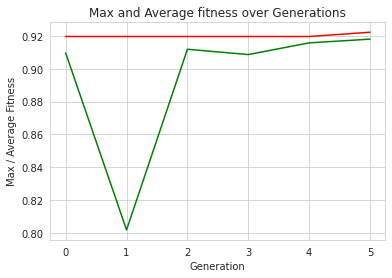

In [ ]:
# create initial population (generation 0):
population  = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# perform the Genetic Algorithm flow with hof feature added:
population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# print best solution found:
best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])

# extract statistics:
maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

# plot statistics:
sns.set_style("whitegrid")
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average fitness over Generations')
plt.show()

Test on testset:

In [ ]:
ensemble = EnsembleVGG(test_images_vgg)
ensemble.ensemble_and_evaluate(hof[0])

7/7 [==============================] - 37s 5s/step - loss: 0.0000e+00 - accuracy: 0.9586


0.9586206674575806

### ResNet Ensemble class

In [ ]:
class EnsembleResNet:
    def __init__(self, set_resnet):
        self.set_resnet = set_resnet

        # create list of models
        self.model_list = []

        base_dir = '/content/drive/MyDrive/Fazzari_Ramo/Models/'
        # ResNet
        resnet = resnet50 + resnet101
        for i, name in enumerate(resnet):
            if i < len(resnet50):
                tmp = ks.models.load_model(base_dir + 'resnet50/' + name)
            else:
                tmp = ks.models.load_model(base_dir + 'resnet101/' + name)
            tmp._name = name
            for j, layer in enumerate(tmp.layers):
                layer.trainable = False
                layer._name = 'ensemble_' + str(j + 1) + '_' + layer.name

            self.model_list.append(tmp)



    def ensembleModel(self, active_models):
        models = []
        for i, model in enumerate(self.model_list):
            if active_models[i] == 1:
                model._name = str(i)
                models.append(model)
        model_input = ks.Input(shape=(IMAGE_WIDTH_RESNET, IMAGE_HEIGHT_RESNET, 3))
        model_outputs = [model(model_input) for model in models]
        ensemble_output = ks.layers.Average()(model_outputs)
        ensemble_model = ks.Model(inputs=model_input, outputs=ensemble_output)
        ensemble_model.compile(metrics=['accuracy'])
        return ensemble_model

    def evaluate(self, ensemble_model):
        loss, acc = ensemble_model.evaluate(self.set_resnet)
        return acc

    def ensemble_and_evaluate(self, active_models):
        if np.sum(active_models) == 0:
            return 0.0
        elif np.sum(active_models) == 1:
            print(active_models.index(1))
            return self.evaluate(self.model_list[active_models.index(1)])
        else:
            return self.evaluate(self.ensembleModel(active_models))

    def models_len(self):
        return len(self.model_list)

Next step is to define the problem (we also save the number of the 

In [ ]:
ensemble = EnsembleResNet(val_images_resnet)
INDIVIDUAL_LENGTH = ensemble.models_len()

We define the Genetic Algorithm constans:

In [ ]:
POPULATION_SIZE = 8
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 5
HALL_OF_FAME_SIZE = 1

We set the random seed:

In [ ]:
RANDOM_SEED = 42 
random.seed(RANDOM_SEED)

We create the toolbox:

In [ ]:
toolbox = base.Toolbox()

Then we define the functions for creating the population:

In [ ]:
# create an operator that randomly returns 0 or 1
toolbox.register('zeroOrOne', random.randint, 0, 1)

# define a single objective, maximizing fitness strategy:
creator.create('FitnessMax', base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create('Individual', list, fitness=creator.FitnessMax)

# create the individual operator to fill up an Individual instance:
toolbox.register('individualCreator', tools.initRepeat, creator.Individual, toolbox.zeroOrOne, INDIVIDUAL_LENGTH)

# create the population operator to generate a list of individual
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


We define the fitness:

In [ ]:
def ensembleAccuracy(individual):
    return ensemble.ensemble_and_evaluate(individual),

toolbox.register('evaluate', ensembleAccuracy)

Now, we can define the genetic operators:


*   Selection: tournament selection
*   Crossover: two point crossover
*  Mutation: multiple flip bit



In [ ]:
# Tournament selection with tournament size of 2:
toolbox.register("select", tools.selTournament, tournsize=2)

# Single-point crossover:
toolbox.register("mate", tools.cxTwoPoint)

# flip-bit mutation:
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/INDIVIDUAL_LENGTH)

### Genetic Algorithm flow:

Define the elitism flow function:

In [ ]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

Flow:

7/7 [==============================] - 24s 2s/step - loss: 0.0000e+00 - accuracy: 0.8212
gen	nevals	max     	avg     
0  	8     	0.821244	0.778174
7/7 [==============================] - 32s 2s/step - loss: 0.0000e+00 - accuracy: 0.8187
1  	4     	0.821244	0.777526
7/7 [==============================] - 32s 2s/step - loss: 0.0000e+00 - accuracy: 0.8031
2  	4     	0.821244	0.791451
7/7 [==============================] - 27s 2s/step - loss: 0.0000e+00 - accuracy: 0.7332
3  	6     	0.821244	0.788536
7/7 [==============================] - 58s 4s/step - loss: 0.0000e+00 - accuracy: 0.8109
4  	5     	0.821244	0.79987 
7/7 [==============================] - 25s 2s/step - loss: 0.0000e+00 - accuracy: 0.8212
5  	6     	0.821244	0.786917
-- Best Ever Individual =  [0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]
-- Best Ever Fitness =  0.8212435245513916


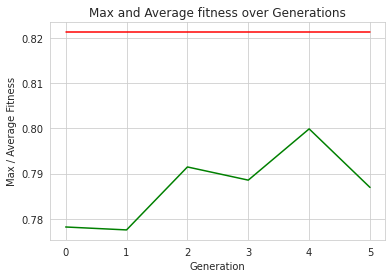

In [ ]:
# create initial population (generation 0):
population  = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# perform the Genetic Algorithm flow with hof feature added:
population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# print best solution found:
best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])

# extract statistics:
maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

# plot statistics:
sns.set_style("whitegrid")
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average fitness over Generations')
plt.show()

Test on test set

In [ ]:
ensemble = EnsembleResNet(test_images_resnet)
ensemble.ensemble_and_evaluate(hof[0])

7/7 [==============================] - 20s 2s/step - loss: 0.0000e+00 - accuracy: 0.9517


0.951724112033844

### Inception Ensemble class

In [ ]:
class EnsembleInception:
    def __init__(self, set_inception):
        self.set_inception = set_inception

        # create list of models
        self.model_list = []

        base_dir = '/content/drive/MyDrive/Fazzari_Ramo/Models/'
        # VGG16
        for name in inception:
            tmp = ks.models.load_model(base_dir + 'inception/' + name)
            tmp._name = name
            for i, layer in enumerate(tmp.layers):
                layer.trainable = False
                layer._name = 'ensemble_' + str(i + 1) + '_' + layer.name
            self.model_list.append(ks.models.load_model(base_dir + 'inception/' + name))


    def ensembleModel(self, active_models):
        models = []
        for i, model in enumerate(self.model_list):
            if active_models[i] == 1:
                model._name = str(i)
                models.append(model)
        model_input = ks.Input(shape=(IMAGE_WIDTH_INCEPTION, IMAGE_HEIGHT_INCEPTION, 3))
        model_outputs = [model(model_input) for model in models]
        ensemble_output = ks.layers.Average()(model_outputs)
        ensemble_model = ks.Model(inputs=model_input, outputs=ensemble_output)
        ensemble_model.compile(metrics=['accuracy'])
        return ensemble_model

    def evaluate(self, ensemble_model):
        loss, acc = ensemble_model.evaluate(self.set_inception)
        return acc

    def ensemble_and_evaluate(self, active_models):
        if np.sum(active_models) == 0:
            return 0.0
        elif np.sum(active_models) == 1:
            print(active_models.index(1))
            return self.evaluate(self.model_list[active_models.index(1)])
        else:
            return self.evaluate(self.ensembleModel(active_models))

    def models_len(self):
        return len(self.model_list)

Next step is to define the problem (we also save the number of the 

In [ ]:
ensemble = EnsembleInception(val_images_inception)
INDIVIDUAL_LENGTH = ensemble.models_len()

We define the Genetic Algorithm constans:

In [ ]:
POPULATION_SIZE = 8
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 5
HALL_OF_FAME_SIZE = 1

We set the random seed:

In [ ]:
RANDOM_SEED = 42 
random.seed(RANDOM_SEED)

We create the toolbox:

In [ ]:
toolbox = base.Toolbox()

Then we define the functions for creating the population:

In [ ]:
# create an operator that randomly returns 0 or 1
toolbox.register('zeroOrOne', random.randint, 0, 1)

# define a single objective, maximizing fitness strategy:
creator.create('FitnessMax', base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create('Individual', list, fitness=creator.FitnessMax)

# create the individual operator to fill up an Individual instance:
toolbox.register('individualCreator', tools.initRepeat, creator.Individual, toolbox.zeroOrOne, INDIVIDUAL_LENGTH)

# create the population operator to generate a list of individual
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


We define the fitness:

In [ ]:
def ensembleAccuracy(individual):
    return ensemble.ensemble_and_evaluate(individual),

toolbox.register('evaluate', ensembleAccuracy)

Now, we can define the genetic operators:


*   Selection: tournament selection
*   Crossover: two point crossover
*  Mutation: multiple flip bit



In [ ]:
# Tournament selection with tournament size of 2:
toolbox.register("select", tools.selTournament, tournsize=2)

# Single-point crossover:
toolbox.register("mate", tools.cxTwoPoint)

# flip-bit mutation:
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/INDIVIDUAL_LENGTH)

### Genetic Algorithm flow:

Define the elitism flow function:

In [ ]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

Flow:

27/7 [==============================] - 13s 687ms/step - loss: 1.7853 - accuracy: 0.3472
3
7/7 [==============================] - 20s 1s/step - loss: 0.0000e+00 - accuracy: 0.8912
2
7/7 [==============================] - 14s 901ms/step - loss: 0.0000e+00 - accuracy: 0.8834
gen	nevals	max     	avg     
0  	8     	0.893782	0.642163
7/7 [==============================] - 14s 897ms/step - loss: 0.0000e+00 - accuracy: 0.8938
1  	6     	0.893782	0.888601
7/7 [==============================] - 14s 899ms/step - loss: 0.0000e+00 - accuracy: 0.8834
3
7/7 [==============================] - 14s 892ms/step - loss: 0.0000e+00 - accuracy: 0.8938
2  	6     	0.893782	0.889896
3
7/7 [==============================] - 20s 898ms/step - loss: 0.0000e+00 - accuracy: 0.8938
3
7/7 [==============================] - 6s 466ms/step - loss: 0.3675 - accuracy: 0.8938
3  	6     	0.893782	0.892487
4
7/7 [==============================] - 14s 899ms/step - loss: 0.0000e+00 - accuracy: 0.8938
3
7/7 [===================

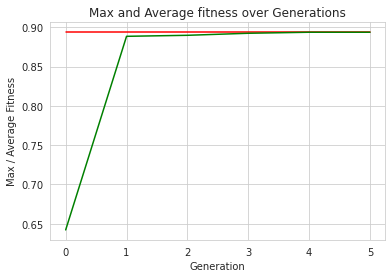

In [ ]:
# create initial population (generation 0):
population  = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# perform the Genetic Algorithm flow with hof feature added:
population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# print best solution found:
best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])

# extract statistics:
maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

# plot statistics:
sns.set_style("whitegrid")
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average fitness over Generations')
plt.show()

Test the result obtained on the test set:

In [ ]:
ensemble = EnsembleInception(test_images_inception)
ensemble.ensemble_and_evaluate(hof[0])

3
7/7 [==============================] - 12s 1s/step - loss: 0.3000 - accuracy: 0.9264


0.9264367818832397